# 3D Face Plot

Process faces for Georgetown Color of Surveillance

In [128]:
%load_ext autoreload
%autoreload 2
import os
from os.path import join
import sys
import time
import cv2 as cv
import numpy as np
import imutils
import matplotlib.animation
%matplotlib notebook
from glob import glob
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from random import randint
sys.path.append('/megapixels/3rdparty/face-alignment')
import face_alignment
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
import random
from skimage import io
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
from pathlib import Path


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# init 3d face
# Run the 3D face alignment on a test image, without CUDA.
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, 
                                  enable_cuda=True, flip_input=True)

In [4]:
data_bodega = '/megapixels/data_bodega/'
fp = join(data_bodega,'images/senators/*.jpg')
face_files = glob(fp,recursive=True)
print(len(face_files))

100


In [97]:

def ensure_dir(d):
  """Create directory if not exist
    :param d: path to directory
  """
  if not os.path.exists(d):
      os.makedirs(d, exist_ok=True)

In [109]:
def generate_3d_face(fpath,output_dir,anim=False,ext='png'):
  # load image
  im = io.imread(fpath)
  
  # generate 3d predictions
  preds = fa.get_landmarks(im)
  if preds is None:
    return
  preds = preds[-1]
  
  # plot style
  num_frames = 60
  lw = 2 # line weight
  bg_color = '#%02x%02x%02x' % (60,59,110)
  mark_clr = '#%02x%02x%02x' % (255,255,255)
  mark_clr = '#%02x%02x%02x' % (0,255,0)
  #mark_type='$\star$'
  #mark_size = 20
  mark_type='o'
  mark_size = 10
  rh = '#ffffff'
  dpi = 72
  figsize = (16,16)
  
  # center x,y,z
  xmm = (np.min(preds[:,0]),np.max(preds[:,0]))
  ymm = (np.min(preds[:,1]),np.max(preds[:,1]))
  zmm = (np.min(preds[:,2]),np.max(preds[:,2]))
  
  preds_orig = preds.copy()
  xmm_sc = (1.2*np.min(preds[:,0]),1.2*np.max(preds_orig[:,0]))
  xmm = (np.min(preds_orig[:,0]),np.max(preds_orig[:,0]))
  ymm = (np.min(preds_orig[:,1]),np.max(preds_orig[:,1]))
  zmm = (np.min(preds_orig[:,2]),np.max(preds_orig[:,2]))
  
  # swap the y and z components to improve 3d rotation angles
  preds = np.zeros_like(preds_orig).astype(np.uint8)
  for i,p in enumerate(preds_orig):
    x,y,z = p
    #preds[i] = np.array([x - xmm[0], y - ymm[0], z - zmm[0]]) # ?
    preds[i] = np.array([x - xmm[0], z - zmm[0], y - ymm[0]])
  
  # Create plot
  fig = plt.figure(figsize=figsize,dpi=dpi)
  fig.tight_layout()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_facecolor(bg_color) # background color
  
  preds_plot = np.zeros_like(preds)
  for i,p in enumerate(preds):
    x,y,z = p
    preds_plot[i] = np.array([x,y,z])

  
  # scatter plot the dots
  ax.plot3D(preds_plot[:17,0]*1.2,preds_plot[:17,1], preds_plot[:17,2],
            marker=mark_type,markersize=mark_size,color=mark_clr,linewidth=lw)
  ax.plot3D(preds_plot[17:22,0]*1.2,preds_plot[17:22,1],preds_plot[17:22,2],
            marker=mark_type,markersize=mark_size,color=mark_clr,linewidth=lw)
  ax.plot3D(preds_plot[22:27,0]*1.2,preds_plot[22:27,1],preds_plot[22:27,2], 
            marker=mark_type,markersize=mark_size,color=mark_clr,linewidth=lw)
  ax.plot3D(preds_plot[27:31,0]*1.2,preds_plot[27:31,1],preds_plot[27:31,2],
            marker=mark_type,markersize=mark_size,color=mark_clr,linewidth=lw)
  ax.plot3D(preds_plot[31:36,0]*1.2,preds_plot[31:36,1],preds_plot[31:36,2],
            marker=mark_type,markersize=mark_size,color=mark_clr,linewidth=lw)
  ax.plot3D(preds_plot[36:42,0]*1.2,preds_plot[36:42,1],preds_plot[36:42,2],
            marker=mark_type,markersize=mark_size,color=mark_clr,linewidth=lw)
  ax.plot3D(preds_plot[42:48,0]*1.2,preds_plot[42:48,1],preds_plot[42:48,2],
            marker=mark_type,markersize=mark_size,color=mark_clr,linewidth=lw)
  ax.plot3D(preds_plot[48:,0]*1.2,preds_plot[48:,1],preds_plot[48:,2],
            marker=mark_type,markersize=mark_size,color=mark_clr, linewidth=lw)

  
  ax.scatter(preds_plot[:,0]*1.2,preds_plot[:,1],preds_plot[:,2],c=rh, alpha=1.0, s=35, edgecolor=rh)
  
  # center points
  cx = ((xmm[0] - xmm[1]) // 2) + xmm[1]
  cy = ((ymm[1] - ymm[0]) // 2) + ymm[0]
  cz = ((zmm[1] - zmm[0]) // 2) + zmm[0]
  
  # ?
  ax.view_init(elev=120., azim=70.)
  
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])
  ax.set_axis_off()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  
  phis = np.linspace(0, 2*np.pi, num_frames)
  
  if anim:
    def update(phi):
       ax.view_init(180,phi*180./np.pi)
    fname_out = join(output_dir,'{}.gif'.format(Path(fpath).stem))
    ani = matplotlib.animation.FuncAnimation(fig, update, frames=phis)
    ani.save(fname_out, writer='imagemagick', fps=10)
    del ani
  else:
    for i,phi in enumerate(phis):
      # ext (jpg,png,pdf)
      person_name = Path(fpath).stem
      fname_out = join(output_dir,person_name,'{}.{}'.format(str(i).zfill(4), ext))
      ensure_dir(Path(fname_out).parent)
      ax.view_init(180,phi*180./np.pi)
      fig.savefig(fname_out, transparent=True)

In [110]:
output_dir = join(data_bodega,'output','senators_3d_points_frames')

In [123]:
for f in tqdm(face_files):
  generate_3d_face(f,output_dir)
  clear_output()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [130]:
im = cv.imread('/data_store/datasets/gov/images/senators/wyden_ron.jpg')
im.shape

(550, 450, 3)

<IPython.core.display.Javascript object>


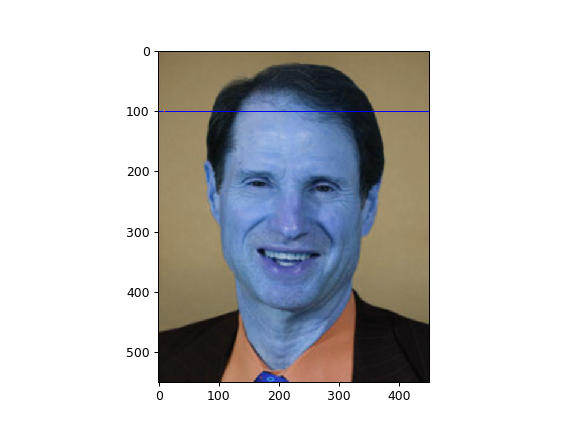

In [132]:
im[100][10] = (255,0,0)
plt.imshow(im)

In [148]:
import pickle
from slugify import slugify

In [149]:
help(slugify)

Help on function slugify in module slugify:

slugify(string)
    Slugify a unicode string.
    
    Example:
    
        >>> slugify(u"Héllø Wörld")
        u"hello-world"



In [138]:
f = '/data_store/datasets/gov/output/senators_obj_04/boozman_john_mesh.pkl'
with open(f, 'rb') as fp:
    data = pickle.load(fp)

In [139]:
for k,v in data.items():
  print(k)

colors
width
keypoints
triangles
texture
vertices
uv_coords
save_vertices
position
pose
camera_matrix
height


In [147]:
print(data['texture'])

[[[0.37254902 0.30588235 0.24313725]
  [0.44313725 0.53333333 0.59607843]
  [0.0627451  0.05882353 0.04313725]
  ...
  [0.65490196 0.51764706 0.44313725]
  [0.60392157 0.4627451  0.36078431]
  [0.33333333 0.25882353 0.23529412]]

 [[0.38039216 0.28627451 0.19215686]
  [0.43137255 0.53333333 0.59215686]
  [0.09803922 0.09411765 0.0745098 ]
  ...
  [0.38039216 0.31372549 0.25098039]
  [0.23921569 0.20784314 0.15686275]
  [0.28235294 0.23137255 0.19607843]]

 [[0.32156863 0.25098039 0.16470588]
  [0.10196078 0.10588235 0.08235294]
  [0.11372549 0.11764706 0.09803922]
  ...
  [0.23529412 0.19607843 0.16078431]
  [0.12156863 0.10980392 0.08235294]
  [0.61960784 0.49803922 0.38823529]]

 ...

 [[0.38039216 0.45882353 0.50196078]
  [0.35294118 0.43921569 0.49411765]
  [0.23529412 0.2627451  0.30196078]
  ...
  [0.72156863 0.49803922 0.39215686]
  [0.10196078 0.10196078 0.13333333]
  [0.0627451  0.06666667 0.08235294]]

 [[0.         0.         0.        ]
  [0.0745098  0.07843137 0.09803922]
